<a href="https://colab.research.google.com/github/mailazorzan/vehicle_sound_classification/blob/main/vehicle_sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Sound Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Bibliotecas para Processamento de Audio
import librosa
from scipy import signal
# Biblioteca para tocar o Audio
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K

In [3]:
path='/content/drive/MyDrive/Portfolio/Vehicle Sound Classification/data/emergency.wav'
emergency,sample_rate    = librosa.load(path, sr = 16000)
path='/content/drive/MyDrive/Portfolio/Vehicle Sound Classification/data/non_emergency.wav'
non_emergency,sample_rate= librosa.load(path, sr =16000)

*  **sr**: taxa de amostragem (sampling rate), ou número de amostras por 
segundo.

Usamos a taxa de *16000* para ler os dois áudios e a duração desses áudios é em torno de 23 e 27 minutos.

Para treinar um modelo de deep learning estamos processando o conjunto de audio em chunks para podermos classificá-los.

In [4]:
duration1 = librosa.get_duration(emergency,sr=16000)
duration2 = librosa.get_duration(non_emergency,sr=16000)
print("Duracao de uma Emergencia e uma Nao Emergencia (em min):",duration1/60,duration2/60)

Duracao de uma Emergencia e uma Nao Emergencia (em min): 22.920290625 27.160834375


In [5]:
def prepare_data(samples, num_of_samples=32000, num_of_common=16000):
  data=[]
  for offset in range(0, len(samples), num_of_common):
    start = offset
    end   = offset + num_of_samples
    chunk = samples[start:end]
    if(len(chunk)==32000):
      data.append(chunk)
  return data

In [6]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [7]:
print("Número de Chunks de Emergência e Não Emergência:",len(emergency),len(non_emergency))

Número de Chunks de Emergência e Não Emergência: 1374 1628


Text(0, 0.5, 'Amplitude')

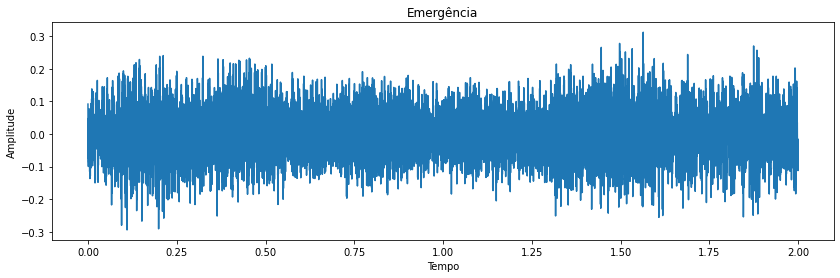

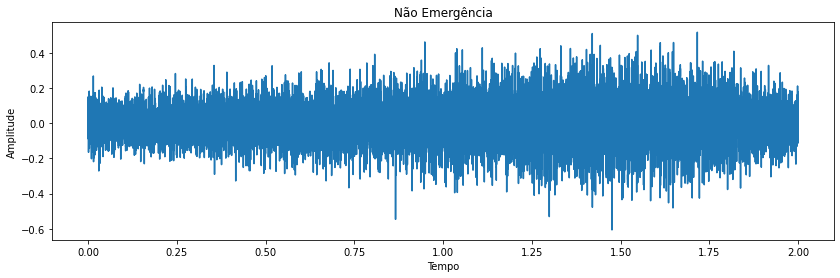

In [8]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergência')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Não Emergência')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')

In [9]:
audio = np.concatenate([emergency,non_emergency])
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))
labels = np.concatenate([labels1,labels2])
print(audio.shape)

(3002, 32000)


In [10]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                            stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [11]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)
print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


# Usando CNN

In [12]:
def cnn(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)
  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)
  #MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)
  #Dense Layer 
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)
  model = Model(inputs, outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc',
                                 verbose=1, save_best_only=True, mode='max')
  return model, model_checkpoint
model, model_checkpoint = cnn(x_tr_features)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16000, 8)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

In [14]:
history=model.fit(x_tr_features, y_tr ,epochs=10, callbacks=[model_checkpoint], 
batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6141 - acc: 0.7379
Epoch 00001: val_acc improved from -inf to 0.78073, saving model to best_model.hdf5
85/85 [==============================] - 74s 857ms/step - loss: 0.6141 - acc: 0.7379 - val_loss: 0.5905 - val_acc: 0.7807
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.4634 - acc: 0.8193
Epoch 00002: val_acc improved from 0.78073 to 0.81395, saving model to best_model.hdf5
85/85 [==============================] - 74s 873ms/step - loss: 0.4634 - acc: 0.8193 - val_loss: 0.4939 - val_acc: 0.8140
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.3716 - acc: 0.8560
Epoch 00003: val_acc improved from 0.81395 to 0.84385, saving model to best_model.hdf5
85/85 [==============================] - 72s 851ms/step - loss: 0.3716 - acc: 0.8560 - val_loss: 0.4168 - val_acc: 0.8439
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.3362 - acc: 0.8623
Epoch 00004: val_acc

In [15]:
model.load_weights('best_model.hdf5')

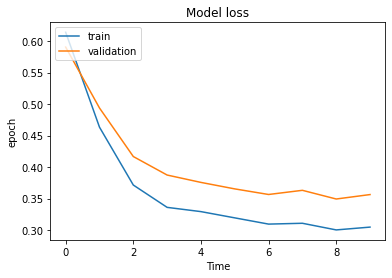

In [16]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

In [17]:
_, acc = model.evaluate(x_val_features,y_val)
print("Acurácia da Validação:",acc)

10/10 [==============================] - 2s 203ms/step - loss: 0.3494 - acc: 0.8837
Acurácia da Validação: 0.8837209343910217


In [18]:
ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5 ):
  pred='Emergência'
else:
  pred='Não Emergência'
print("Predição:",pred)

Predição: Emergência


# Usando LSTM

Readequamos o formato do treino com 160, pois isso irá fazer com que os 3200 steps, que teríamos caso não fizessemos essa transformação, virem apenas 200, e assim podemos usá-los mais facilmente em nosso modelo.

In [19]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)
print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [20]:
def lstm(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
  # Adicionando LSTM
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  # Adicionando as funções de ativação das camadas densas
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  model = Model(inputs, x)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  return model

model = lstm(x_tr_features)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156,289
Trainable params: 156,289
Non-trainable params: 0
_________________________________________________________________


In [21]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1,
                     save_best_only=True, mode='max')

In [22]:
history = model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.5628
Epoch 00001: val_acc improved from -inf to 0.57475, saving model to best_model.hdf5
85/85 [==============================] - 25s 261ms/step - loss: 0.6924 - acc: 0.5628 - val_loss: 0.6808 - val_acc: 0.5748
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.6244 - acc: 0.6638
Epoch 00002: val_acc improved from 0.57475 to 0.74751, saving model to best_model.hdf5
85/85 [==============================] - 21s 249ms/step - loss: 0.6244 - acc: 0.6638 - val_loss: 0.5359 - val_acc: 0.7475
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.5985 - acc: 0.6868
Epoch 00003: val_acc did not improve from 0.74751
85/85 [==============================] - 21s 252ms/step - loss: 0.5985 - acc: 0.6868 - val_loss: 0.7097 - val_acc: 0.6711
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.6444 - acc: 0.6357
Epoch 00004: val_acc did not improve from 0.74751
85/85 [

In [23]:
model.load_weights('best_model.hdf5')

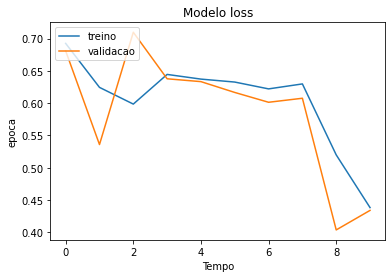

In [24]:
# Histórico para a loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo loss')
plt.xlabel('Tempo')
plt.ylabel('epoca')
plt.legend(['treino','validacao'],loc = 'upper left')
plt.show()

In [25]:
_,acc = model.evaluate(x_val_features,y_val)
print("Acurácia:",acc)

10/10 [==============================] - 1s 75ms/step - loss: 0.4038 - acc: 0.8239
Acurácia: 0.8239202499389648


Observando as curvas de loss da CNN e da LSTM, podemos perceber que o modelo utilizando a CNN tem uma curva de loss mais suave do que a LSTM, e isso pode contribuir para termos uma ideia melhor da previsibilidade do modelo, já que sua curva tem um comportamento tendendo a algo mais "prevísivel".